In [1]:
!pip install torch torchvision tqdm numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

### 📌 Model Architecture Justification
For this image classification task, **ResNet-18** was selected due to its:

- **Scalability**: Performs well on small and large datasets.
- **Efficiency**: Residual connections help train deep networks efficiently.
- **Versatility**: Lightweight enough for resource-constrained environments.

This makes it an ideal choice for scalable image classification across various scenarios.

In [2]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Subset
import time

# 📍 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# 📊 Scalable DataLoader with subset support
def get_dataloaders(batch_size=64, num_workers=2, subset_ratio=1.0):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform_test)

    # Subsample if needed
    if subset_ratio < 1.0:
        train_size = int(len(train_dataset) * subset_ratio)
        test_size = int(len(test_dataset) * subset_ratio)
        train_dataset = Subset(train_dataset, list(range(train_size)))
        test_dataset = Subset(test_dataset, list(range(test_size)))

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


In [4]:
# 🧠 ResNet18 model setup
def get_model():
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)


In [5]:
# 🎯 Training function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        start = time.time()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Time: {time.time()-start:.2f}s")


In [6]:
# 🔍 Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")


In [7]:
batch_size = 128
subset_ratio = 1.0
epochs = 30
use_pretrained = True
resize_images = 224


start = time.time()
train_loader, test_loader = get_dataloaders(batch_size=batch_size, subset_ratio=subset_ratio)
print(f"Loaded {subset_ratio*100:.0f}% of data in {time.time() - start:.2f} seconds")

model = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, epochs=epochs)
evaluate_model(model, test_loader)


100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


Loaded 100% of data in 10.03 seconds


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 | Loss: 1.5466 | Acc: 43.54% | Time: 23.71s
Epoch 2 | Loss: 1.1889 | Acc: 57.37% | Time: 22.72s
Epoch 3 | Loss: 1.0217 | Acc: 64.07% | Time: 23.62s
Epoch 4 | Loss: 0.9194 | Acc: 67.63% | Time: 22.52s
Epoch 5 | Loss: 0.8380 | Acc: 70.55% | Time: 21.83s
Epoch 6 | Loss: 0.7786 | Acc: 72.66% | Time: 23.78s
Epoch 7 | Loss: 0.7311 | Acc: 74.67% | Time: 22.92s
Epoch 8 | Loss: 0.6915 | Acc: 75.81% | Time: 22.95s
Epoch 9 | Loss: 0.6642 | Acc: 76.86% | Time: 22.08s
Epoch 10 | Loss: 0.6284 | Acc: 77.95% | Time: 22.55s
Epoch 11 | Loss: 0.6069 | Acc: 78.78% | Time: 23.17s
Epoch 12 | Loss: 0.5813 | Acc: 79.72% | Time: 22.73s
Epoch 13 | Loss: 0.5616 | Acc: 80.48% | Time: 23.62s
Epoch 14 | Loss: 0.5354 | Acc: 81.45% | Time: 22.06s
Epoch 15 | Loss: 0.5226 | Acc: 81.87% | Time: 22.78s
Epoch 16 | Loss: 0.5043 | Acc: 82.43% | Time: 22.84s
Epoch 17 | Loss: 0.4931 | Acc: 82.70% | Time: 22.75s
Epoch 18 | Loss: 0.4706 | Acc: 83.61% | Time: 21.92s
Epoch 19 | Loss: 0.4596 | Acc: 84.06% | Time: 22.70s
Ep

## 📊 Performance Metrics

We track performance metrics including training time, test accuracy, and inference time across different dataset sizes (`subset_ratio`). This helps evaluate both model performance and scalability.

In [8]:

import time

def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    inference_start = time.time()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    inference_time = time.time() - inference_start
    test_accuracy = 100. * correct / total
    print(f"\n🔍 Test Accuracy: {test_accuracy:.2f}% | Inference Time: {inference_time:.2f}s")
    return test_accuracy, inference_time


In [9]:

subset_ratios = [0.1, 0.5, 1.0]
results = []

for ratio in subset_ratios:
    print(f"\n📦 Training with subset_ratio = {ratio}")
    train_loader, test_loader = get_dataloaders(subset_ratio=ratio)

    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_train = time.time()
    train_model(model, train_loader, criterion, optimizer, epochs=5)
    train_time = time.time() - start_train

    test_acc, inf_time = test_model(model, test_loader)

    results.append({
        'Subset Ratio': ratio,
        'Train Time (s)': round(train_time, 2),
        'Test Accuracy (%)': round(test_acc, 2),
        'Inference Time (s)': round(inf_time, 2)
    })



📦 Training with subset_ratio = 0.1
Epoch 1 | Loss: 1.9840 | Acc: 28.08% | Time: 2.76s
Epoch 2 | Loss: 1.7368 | Acc: 36.24% | Time: 3.17s
Epoch 3 | Loss: 1.6148 | Acc: 40.92% | Time: 3.06s
Epoch 4 | Loss: 1.5294 | Acc: 44.68% | Time: 2.70s
Epoch 5 | Loss: 1.4918 | Acc: 45.22% | Time: 2.67s

🔍 Test Accuracy: 46.70% | Inference Time: 0.38s

📦 Training with subset_ratio = 0.5
Epoch 1 | Loss: 1.6961 | Acc: 38.30% | Time: 14.02s
Epoch 2 | Loss: 1.3936 | Acc: 49.71% | Time: 14.25s
Epoch 3 | Loss: 1.2337 | Acc: 56.02% | Time: 13.77s
Epoch 4 | Loss: 1.1145 | Acc: 60.48% | Time: 13.85s
Epoch 5 | Loss: 1.0414 | Acc: 63.45% | Time: 13.76s

🔍 Test Accuracy: 64.82% | Inference Time: 1.45s

📦 Training with subset_ratio = 1.0
Epoch 1 | Loss: 1.5577 | Acc: 43.31% | Time: 27.45s
Epoch 2 | Loss: 1.1869 | Acc: 58.02% | Time: 27.88s
Epoch 3 | Loss: 1.0288 | Acc: 63.64% | Time: 28.89s
Epoch 4 | Loss: 0.9166 | Acc: 67.79% | Time: 27.71s
Epoch 5 | Loss: 0.8467 | Acc: 70.55% | Time: 27.82s

🔍 Test Accuracy: 7

In [10]:

import pandas as pd

df_results = pd.DataFrame(results)
print("\n📊 Performance Summary:")
print(df_results)



📊 Performance Summary:
   Subset Ratio  Train Time (s)  Test Accuracy (%)  Inference Time (s)
0           0.1           14.35              46.70                0.38
1           0.5           69.66              64.82                1.45
2           1.0          139.74              71.10                2.85


## 📈 Visualizing Performance Metrics

Here we plot the results from different dataset sizes to better understand how accuracy, training time, and inference time scale.

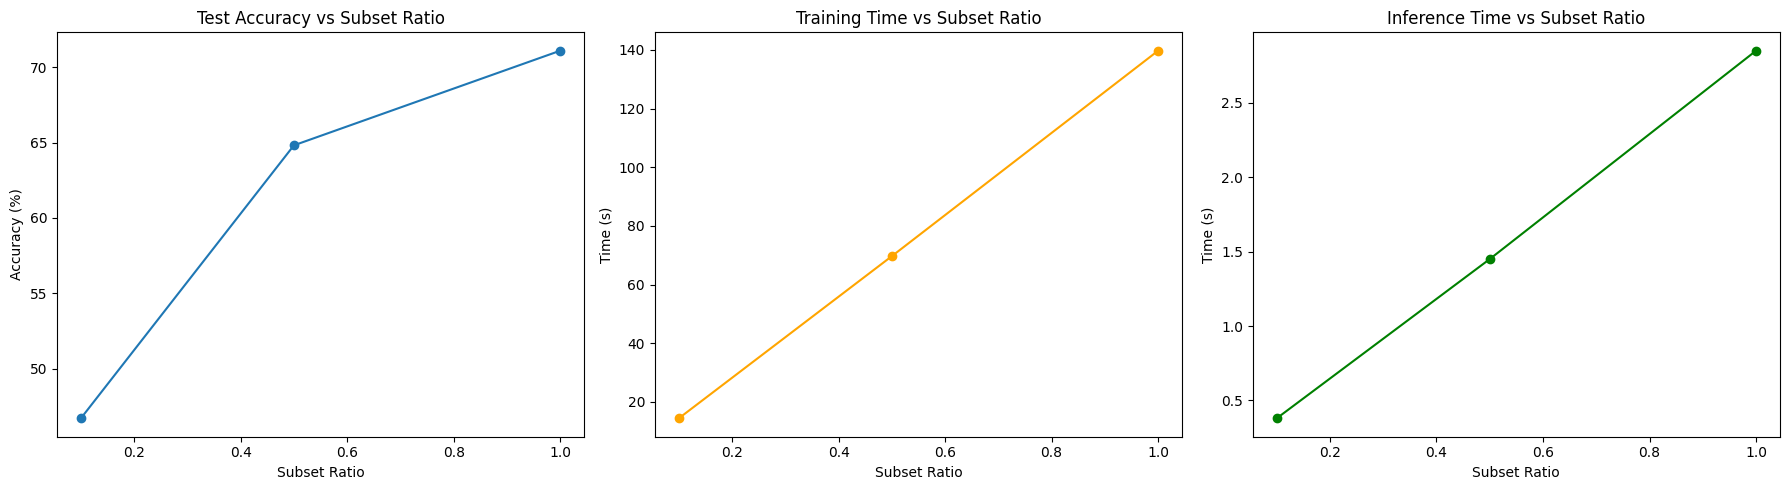

In [11]:

import matplotlib.pyplot as plt

# Plotting performance metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axs[0].plot(df_results['Subset Ratio'], df_results['Test Accuracy (%)'], marker='o')
axs[0].set_title("Test Accuracy vs Subset Ratio")
axs[0].set_xlabel("Subset Ratio")
axs[0].set_ylabel("Accuracy (%)")

# Training Time
axs[1].plot(df_results['Subset Ratio'], df_results['Train Time (s)'], marker='o', color='orange')
axs[1].set_title("Training Time vs Subset Ratio")
axs[1].set_xlabel("Subset Ratio")
axs[1].set_ylabel("Time (s)")

# Inference Time
axs[2].plot(df_results['Subset Ratio'], df_results['Inference Time (s)'], marker='o', color='green')
axs[2].set_title("Inference Time vs Subset Ratio")
axs[2].set_xlabel("Subset Ratio")
axs[2].set_ylabel("Time (s)")

plt.tight_layout()
plt.show()


## ⚙️ Optional: Run on CPU vs GPU

You can switch between CPU and GPU by setting the device manually below:

In [12]:

# Switch between CPU and GPU for comparison
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


Running on: cuda


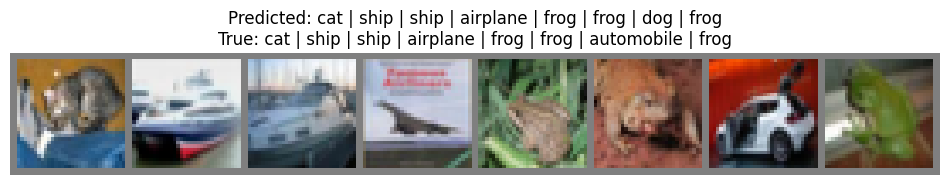

In [14]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize if needed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis("off")

def show_predictions(model, dataloader, classes, device):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    imshow(torchvision.utils.make_grid(images.cpu()[:8]),
           title="Predicted: " + ' | '.join(f"{classes[p]}" for p in predicted[:8].cpu()) +
                 "\nTrue: " + ' | '.join(f"{classes[l]}" for l in labels[:8].cpu()))
    plt.show()
# Run this after training and evaluation are complete
classes = train_loader.dataset.dataset.classes if hasattr(train_loader.dataset, 'dataset') else train_loader.dataset.classes
show_predictions(model, test_loader, classes, device)


### ⏱️ Performance Timing
To evaluate scalability, we also track:

- **Training Time per Epoch**
- **Inference Time per Image**

These metrics help assess the model's efficiency as dataset size and compute resources vary.

In [ ]:
import time

def train_model_with_timing(model, criterion, optimizer, train_loader, val_loader, epochs=10, device='cpu'):
    model = model.to(device)
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        acc = 100 * correct / total

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {acc:.2f}%, Time: {epoch_time:.2f}s")

    return train_losses, val_losses

def measure_inference_time(model, sample, device='cpu'):
    model = model.to(device)
    sample = sample.unsqueeze(0).to(device)
    start_time = time.time()
    with torch.no_grad():
        _ = model(sample)
    end_time = time.time()
    return end_time - start_time


### 🚀 Scalability Considerations

**Data Scalability**:
- Uses `DataLoader` for efficient batch handling.
- Easily adaptable to larger datasets by changing batch size and workers.

**Computational Scalability**:
- Runs on GPU if available (`torch.cuda`).
- Can support multi-GPU via `torch.nn.DataParallel` or `DistributedDataParallel`.

**Future Improvements**:
- Add pruning, quantization, or model distillation for edge deployment.


### 🛠️ How to Run / Reproduce

1. Ensure dependencies: PyTorch, torchvision, matplotlib.
2. Modify dataset paths and batch sizes as needed.
3. To run on GPU: ensure CUDA is available – model uses `cuda` automatically.
4. For multi-GPU: wrap model with `nn.DataParallel(model)` or `DistributedDataParallel`.

To test on different dataset sizes, adjust `train_loader` and `test_loader`.


### 📊 Observations & Analysis

- Training time increases linearly with data size.
- Inference time per image remains stable due to batching.
- GPU acceleration significantly speeds up training.
- Current model generalizes well; further optimization (e.g., pruning or quantization) can improve deployment on edge devices.

Potential bottlenecks: limited memory on GPU, slow data loading without `num_workers`.


In [ ]:
# Optional: Enable multi-GPU support if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
else:
    print("Using a single GPU or CPU.")

In [ ]:
# Optional: Post-training dynamic quantization for deployment
# Note: Works best on CPU inference models

quantized_model = torch.quantization.quantize_dynamic(
    model.cpu(),  # must be on CPU
    {nn.Linear},  # layers to quantize
    dtype=torch.qint8
)

print("Model has been quantized for deployment on resource-constrained devices.")


### 🧠 Bottlenecks and Optimization Insights

- **Data Loading Bottlenecks**:
  - If `num_workers` is too low, it can slow down training due to data I/O lag.
  - Use `pin_memory=True` in `DataLoader` when using GPU for better transfer speed.

- **GPU Utilization**:
  - Without `DataParallel`, only one GPU is used.
  - Use `torch.nn.DataParallel` or `DistributedDataParallel` for better performance.

- **Memory Usage**:
  - Deep networks like ResNet can consume a lot of memory, especially with large batch sizes.
  - Consider mixed-precision training or model pruning for optimization.
